### Create a master dataframe with all _C. elegans_ datasets for plotting with `seaborn`.
---
*Last updated: 10 July 2023*

In [5]:
# %load_ext cudf.pandas
import torch
import random
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.cm
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import HTML
from data._utils import load_dataset
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.animation import FuncAnimation
from utils import NEURONS_302, VALID_DATASETS, SYNTHETIC_DATASETS, init_random_seeds

# Initialize the random seeds
init_random_seeds(42)

#### Create a short-form dataset `csv`.
---

First we will create a file called `worm_data_short.csv` that aggregates worm data from all the different datasets we have.

In [6]:
%%time

# Custom function to check if all values in a list are 0.0
def all_zeros(lst):
    """
    Custom function to check if all values in a list are 0.0
    """
    return all(val == 0.0 for val in lst)

# Load all worm datasets
all_worm_datasets = [load_dataset(dataset) for dataset in VALID_DATASETS]

# Create a dictionary to store the data for the table
new_dict = dict()

# This loop iterates over all neurons in all worm datasets and extracts relevant information to fill in a table.
# The table is then converted to a pandas dataframe and saved to a CSV file.
# Finally, the dataframe is displayed.

# Iterate over all neurons in all worm datasets
for dataset in all_worm_datasets:
    for worm in dataset:
        for neuron, slot in dataset[worm]["neuron_to_slot"].items():
            # get data to fill in the table
            dataset_name = dataset[worm]["source_dataset"]
            smooth_method = dataset[worm]["smooth_method"]
            interpolate_method = dataset[worm]["interpolate_method"]
            # calcium data
            original_calcium_data = dataset[worm]["original_calcium_data"][:, slot].numpy()
            calcium_data = dataset[worm]["calcium_data"][:, slot].numpy()
            # ignore neurons with no calcium data
            if all_zeros(calcium_data):
                continue
            original_smooth_calcium_data = dataset[worm]["original_smooth_calcium_data"][:, slot].numpy()
            smooth_calcium_data = dataset[worm]["smooth_calcium_data"][:, slot].numpy()
            original_residual_calcium = dataset[worm]["original_residual_calcium"][:, slot].numpy()
            residual_calcium = dataset[worm]["residual_calcium"][:, slot].numpy()
            original_smooth_residual_calcium = dataset[worm]["original_smooth_residual_calcium"][
                :, slot
            ].numpy()
            smooth_residual_calcium = dataset[worm]["smooth_residual_calcium"][
                :, slot
            ].numpy()
            # time data
            original_time_in_seconds = dataset[worm]["original_time_in_seconds"].squeeze().numpy() 
            time_in_seconds = dataset[worm]["time_in_seconds"].squeeze().numpy()
            original_dt = dataset[worm]["original_dt"].squeeze().numpy()
            dt = dataset[worm]["dt"].squeeze().numpy()
            median_dt = dataset[worm]["median_dt"]
            max_timesteps = dataset[worm]["max_timesteps"]
            # neuron index data
            if neuron in dataset[worm]["named_neuron_to_slot"]:
                is_named_neuron = True
                is_unknown_neuron = False
            elif neuron in dataset[worm]["unknown_neuron_to_slot"]:
                is_named_neuron = False
                is_unknown_neuron = True
            else:
                # this should never happen if preprocessing was done correctly
                raise Exception(f"Anomalous neuron detected: {neuron}.")
            # fill in table
            new_dict.setdefault("source_dataset", new_dict.get("source_dataset", [])).append(
                dataset_name
            )
            new_dict.setdefault("worm", new_dict.get("worm", [])).append(worm)
            new_dict.setdefault("neuron", new_dict.get("neuron", [])).append(neuron)
            new_dict.setdefault("slot", new_dict.get("slot", [])).append(slot)
            new_dict.setdefault(
                "is_named_neuron", new_dict.get("is_named_neuron", [])
            ).append(is_named_neuron)
            new_dict.setdefault(
                "is_unknown_neuron", new_dict.get("is_unknown_neuron", [])
            ).append(is_unknown_neuron)
            new_dict.setdefault(
                "original_calcium_data", new_dict.get("original_calcium_data", [])
            ).append(original_calcium_data)
            new_dict.setdefault(
                "calcium_data", new_dict.get("calcium_data", [])
            ).append(calcium_data)
            new_dict.setdefault(
                "original_smooth_calcium_data", new_dict.get("original_smooth_calcium_data", [])
            ).append(original_smooth_calcium_data)
            new_dict.setdefault(
                "smooth_calcium_data", new_dict.get("smooth_calcium_data", [])
            ).append(smooth_calcium_data)
            new_dict.setdefault(
                "original_residual_calcium", new_dict.get("original_residual_calcium", [])
            ).append(original_residual_calcium)
            new_dict.setdefault(
                "residual_calcium", new_dict.get("residual_calcium", [])
            ).append(residual_calcium)
            new_dict.setdefault(
                "original_smooth_residual_calcium", new_dict.get("original_smooth_residual_calcium", [])
            ).append(original_smooth_residual_calcium)
            new_dict.setdefault(
                "smooth_residual_calcium", new_dict.get("smooth_residual_calcium", [])
            ).append(smooth_residual_calcium)
            new_dict.setdefault(
                "smooth_method", new_dict.get("smooth_method", [])
            ).append(smooth_method)
            new_dict.setdefault(
                "interpolate_method", new_dict.get("interpolate_method", [])
            ).append(interpolate_method)
            new_dict.setdefault(
                "original_time_in_seconds", new_dict.get("original_time_in_seconds", [])
            ).append(original_time_in_seconds)
            new_dict.setdefault(
                "time_in_seconds", new_dict.get("time_in_seconds", [])
            ).append(time_in_seconds)
            new_dict.setdefault("original_dt", new_dict.get("original_dt", [])).append(original_dt)
            new_dict.setdefault("dt", new_dict.get("dt", [])).append(dt)
            new_dict.setdefault(
                "median_dt", new_dict.get("median_dt", [])
            ).append(median_dt)
            new_dict.setdefault(
                "max_timesteps", new_dict.get("max_timesteps", [])
            ).append(max_timesteps)

# Convert the dictionary to a pandas dataframe
df_short = pd.DataFrame.from_dict(new_dict)

# Save to a CSV file (file size is ~9.0 MB)
pd.DataFrame.to_csv(df_short, "worm_data_short.csv")

# Display the dataframe
df_short

CPU times: user 3min 21s, sys: 4.44 s, total: 3min 25s
Wall time: 3min 30s


,dataset,worm,neuron,slot,is_named_neuron,is_unknown_neuron,original_calcium_data,calcium_data,original_smooth_calcium_data,smooth_calcium_data,...,original_smooth_residual_calcium,smooth_residual_calcium,smooth_method,interpolate_method,original_time_in_seconds,time_in_seconds,original_dt,dt,resample_median_dt,max_timesteps
0,Skora2018,worm0,AIBL,12,True,False,"[0.323, 0.2505, 0.2642, 0.19, 0.2382, 0.1641, ...","[0.2822, 0.247, 0.2139, 0.1741, 0.1207, 0.0934...","[0.323, 0.2866, 0.2754, 0.2327, 0.2354, 0.1997...","[0.302, 0.2686, 0.2343, 0.2019, 0.1531, 0.1178...",...,"[-0.1746, -0.1227, -0.0977, -0.06445, -0.04773...","[-0.1443, -0.095, -0.05756, -0.081, -0.0678, -...",ES,linear,"[0.0, 0.4158, 0.8315, 1.248, 1.663, 2.08, 2.49...","[0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.2, 4.8, ...","[0.4158, 0.4158, 0.416, 0.4158, 0.416, 0.4165,...","[0.6, 0.6, 0.5996, 0.6, 0.6, 0.5996, 0.5996, 0...",0.666,1799
1,Skora2018,worm0,AIBR,13,True,False,"[0.4006, 0.2559, 0.02959, 0.2104, -0.00658, -0...","[0.3108, 0.10205, 0.1005, -0.001168, -0.07336,...","[0.4006, 0.3284, 0.179, 0.1947, 0.09406, 0.046...","[0.3545, 0.2058, 0.1443, 0.05383, -0.01646, -0...",...,"[-0.3481, -0.3972, -0.2258, -0.1346, -0.195, -...","[-0.37, -0.2345, -0.1644, -0.12115, -0.1895, -...",ES,linear,"[0.0, 0.4158, 0.8315, 1.248, 1.663, 2.08, 2.49...","[0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.2, 4.8, ...","[0.4158, 0.4158, 0.416, 0.4158, 0.416, 0.4165,...","[0.6, 0.6, 0.5996, 0.6, 0.6, 0.5996, 0.5996, 0...",0.666,1799
2,Skora2018,worm0,ALA,22,True,False,"[-0.1927, 0.0355, -0.0911, -0.3423, -0.0667, -...","[-0.0675, -0.1219, -0.2062, -0.2683, -0.1516, ...","[-0.1927, -0.0786, -0.08484, -0.2136, -0.1401,...","[-0.1282, -0.1099, -0.1765, -0.2192, -0.1958, ...",...,"[0.549, 0.3354, -0.05942, -0.01506, -0.004566,...","[0.4143, 0.01209, -0.01244, -0.05573, 0.1272, ...",ES,linear,"[0.0, 0.4158, 0.8315, 1.248, 1.663, 2.08, 2.49...","[0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.2, 4.8, ...","[0.4158, 0.4158, 0.416, 0.4158, 0.416, 0.4165,...","[0.6, 0.6, 0.5996, 0.6, 0.6, 0.5996, 0.5996, 0...",0.666,1799
3,Skora2018,worm0,ASJL,47,True,False,"[-0.4404, -1.063, -0.757, -0.4917, -0.7524, -0...","[-0.7837, -0.7515, -0.6226, -0.7227, -0.8794, ...","[-0.4404, -0.752, -0.7544, -0.623, -0.6875, -0...","[-0.617, -0.727, -0.6567, -0.6953, -0.8203, -0...",...,"[-1.497, -0.9385, -0.1257, -0.0604, -0.0981, -...","[-1.152, -0.2412, -0.0834, -0.2357, -0.0768, -...",ES,linear,"[0.0, 0.4158, 0.8315, 1.248, 1.663, 2.08, 2.49...","[0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.2, 4.8, ...","[0.4158, 0.4158, 0.416, 0.4158, 0.416, 0.4165,...","[0.6, 0.6, 0.5996, 0.6, 0.6, 0.5996, 0.5996, 0...",0.666,1799
4,Skora2018,worm0,ASKL,49,True,False,"[-0.7285, -0.5083, -0.682, -0.7476, -0.9023, -...","[-0.6094, -0.668, -0.8223, -0.898, -0.7397, -0...","[-0.7285, -0.618, -0.6504, -0.6987, -0.801, -0...","[-0.667, -0.6553, -0.7485, -0.843, -0.7915, -0...",...,"[0.5303, 0.293, 0.002693, -0.131, -0.1704, -0....","[0.386, 0.02165, -0.1455, -0.02516, 0.06635, 0...",ES,linear,"[0.0, 0.4158, 0.8315, 1.248, 1.663, 2.08, 2.49...","[0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.2, 4.8, ...","[0.4158, 0.4158, 0.416, 0.4158, 0.416, 0.4165,...","[0.6, 0.6, 0.5996, 0.6, 0.6, 0.5996, 0.5996, 0...",0.666,1799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34232,Kato2015,worm11,29,210,False,True,"[1.058, 0.679, 0.3003, 2.377, 0.9653, 1.336, 1...","[0.793, 1.188, 1.311, 1.322, 1.492, 0.8657, 1....","[1.058, 0.868, 0.5845, 1.48, 1.223, 1.279, 1.2...","[0.917, 0.9795, 1.283, 1.291, 1.403, 1.128, 1....",...,"[-1.059, -1.059, 0.658, 0.794, -0.3306, 0.0693...","[-0.9106, 0.597, -0.03107, 0.0917, 0.02972, -0...",ES,linear,"[0.0, 0.3574, 0.715, 1.072, 1.43, 1.787, 2.145...","[0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.2, 4.8, ...","[0.3574, 0.3574, 0.3574, 0.3574, 0.3574, 0.357...","[0.6, 0.6, 0.5996, 0.6, 0.6, 0.5996, 0.5996, 0...",0.666,1799
34233,Kato2015,worm11,54,209,False,True,"[0.1067, 0.3877, -1.785, -0.7446, -0.5776, 0.0..."

In [7]:
# # DEBUG: We can see that each slot corresponds to a unique neuron and that neurons are named consistently across datasets.
# for i in range(302):
#     _ = df_short[df_short["slot"] == i][df_short["is_named_neuron"] == True]
#     print(_.neuron.unique(), _.dataset.unique(), end="\n\n")

This DataFrame `df_short` contains information on neuronal calcium activity of a worm dataset. Some of the main columns are as follows:
* `calcium_data`: A list of the normalized and ressampled calcium activity for the neuron.
* `dataset`: The dataset identifier, e.g. "Kato2015".
* `dt`: A list of time differences between consecutive time points in seconds.
* `interpolate_method`: The method (linear, cubic, quadratic) used to resampling the calcium data to a fixed time step.
* `is_named_neuron`: A boolean indicating if the neuron has a specific name (True) or is indexed by an integer (False).
* `is_unknown_neuron`: A boolean indicating if the neuron is unknown (True) or not (False).
* `max_timesteps`: The maximum number of timesteps for the calcium data.
* `neuron`: Neuron identifier, either a named neuron like "ADAL" or an integer index for unknown neurons.
* `residual_calcium`: A list of residual calcium for the neuron.
* `smooth_calcium_data`: A list of smoothed normalized and resampled calcium activity for the neuron.
* `smooth_method`: The method used for smoothing the calcium data.
* `smooth_residual_calcium`: A list of smoothed residual calcium for the neuron.
* `slot`: An integer index representing the position of the neuron in the dataset.
* `time_in_seconds`: A list of time points in seconds corresponding to the calcium data.
* `worm` : Worm identifier, e.g. "worm0".
---
"calcium_data"
"source_dataset"
"worm"
"neuron"
"slot"
"is_named_neuron"
"is_unknown_neuron"
"original_calcium_data"
"calcium_data"
"original_smooth_calcium_data"
"smooth_calcium_data"
"original_residual_calcium"
"residual_calcium"
"original_smooth_residual_calcium"
"smooth_residual_calcium"
"smooth_method"
"original_time_in_seconds"
"time_in_seconds"
"dt"
"max_timesteps"

#### Convert the dataset to a long-form `csv`.
---

We next restructure our DataFrame to make it more suitable for visualization using `seaborn`. One common format that seaborn works well with is the "long format" or "tidy format". In this format, each row represents a single observation, and each column represents a variable.

To restructure our DataFrame:

1. Create a new DataFrame with only the columns you need for visualization. In this case, let's keep `dataset`, `worm`, `neuron`, `is_named_neuron`, `is_unknown_neuron`, `time_in_seconds`, and `smooth_calcium_data`.

2. Convert the `time_in_seconds` and `smooth_calcium_data` columns, which are lists, into multiple rows with one value per row.

Below is code for restructuring the DataFrame. Please note that this cell may take ~3 minutes to run.

In [8]:
%%time

# Keep only relevant columns
df_visualization = df_short[
    [
        "calcium_data",
        "smooth_calcium_data",
        "source_dataset",
        "dt",
        "is_named_neuron",
        "is_unknown_neuron",
        "max_timesteps",
        "neuron",
        "median_dt",
        "smooth_method",
        "slot",
        "time_in_seconds",
        "worm"
    ]
]

# Create an empty list to store DataFrames
df_list = []

# Loop through the rows of the DataFrame
for _, row in df_visualization.iterrows():
    # Create a temporary DataFrame for each row
    temp_df = pd.DataFrame(
        {
            "dt": row["dt"],
            "calcium_data": row["calcium_data"],
            "smooth_calcium_data": row["smooth_calcium_data"],
            "time_in_seconds": row["time_in_seconds"], 
        }
    )

    # Add constant columns
    temp_df["source_dataset"] = row["source_dataset"]
    temp_df["is_named_neuron"] = row["is_named_neuron"]
    temp_df["is_unknown_neuron"] = row["is_unknown_neuron"]
    temp_df["neuron"] = row["neuron"]
    temp_df["median_dt"] = row["median_dt"]   
    temp_df["slot"] = row["slot"]
    temp_df["smooth_method"] = row["smooth_method"]
    temp_df["worm"] = row["worm"]
    
    # Append the temporary DataFrame to the list
    df_list.append(temp_df)

# Concatenate all the temporary DataFrames into one
df_long = pd.concat(df_list, ignore_index=True)

# Display the dataframe
df_long

CPU times: user 59 s, sys: 7.52 s, total: 1min 6s
Wall time: 1min 11s


,dt,calcium_data,smooth_calcium_data,time_in_seconds,dataset,is_named_neuron,is_unknown_neuron,neuron,resample_median_dt,slot,smooth_method,worm
0,0.600098,0.282227,0.302002,0.000000,Skora2018,True,False,AIBL,0.666,12,ES,worm0
1,0.600098,0.246948,0.268555,0.600098,Skora2018,True,False,AIBL,0.666,12,ES,worm0
2,0.599609,0.213867,0.234253,1.200195,Skora2018,True,False,AIBL,0.666,12,ES,worm0
3,0.600098,0.174072,0.201904,1.799805,Skora2018,True,False,AIBL,0.666,12,ES,worm0
4,0.600098,0.120728,0.153076,2.400391,Skora2018,True,False,AIBL,0.666,12,ES,worm0
...,...,...,...,...,...,...,...,...,...,...,...,...
72126677,0.500000,2.939453,2.892578,1076.000000,Kato2015,False,True,12,0.666,131,ES,worm11
72126678,1.000000,2.724609,2.814453,1077.000000,Kato2015,False,True,12,0.666,131,ES,worm11
72126679,0.500000,2.818359,2.791016,1078.000000,Kato2015,False,True,12,0.666,131,ES,worm11
72126680,0.500000,2.787109,2.822266,1078.000000,Kato2015,False,True,12,0.666,131,ES,worm11


The `df_long` format is better suited for plotting using `seaborn` because `seaborn` works well with long-format data. This format allows us to easily create complex plots, and `seaborn` takes care of grouping, aggregating, and transforming data for the desired visualizations. This is because seaborn functions typically expect data in a tidy long-format data structure, where each row is an observation and columns contain the variables.

#### Create helper functions for plotting.
---

In [9]:
%%time

def plot_neuron_calcium_data(
    neuron,
    dataset,
    df_long=None,
    max_lines=5,
    max_time_seconds=300,
    random_select=False,
):
    """
    Plot the calcium data for specific neurons in a specific dataset,
    limiting the amount of lines in the plot and the maximum time in seconds.

    The function filters the input DataFrame based on the provided neuron and/or dataset
    and plots the 'smooth_calcium_data' over time for each unique worm. It can either
    randomly select a subset of worms or select them based on alphabetical order.

    Parameters
    ----------
    neuron : str, optional
        The name of the neuron to plot data for.

    dataset : str, optional
        The name of the dataset to plot data from.

    df_long : pd.DataFrame
        A pandas DataFrame containing the following columns:
            - 'neuron': The name of the neuron.
            - 'worm': The identifier of the worm.
            - 'dataset': The name of the dataset.
            - 'time_in_seconds': The time in seconds at which the measurement was made.
            - 'smooth_calcium_data': The smooth calcium data to be plotted.

    max_lines : int, default=7
        The maximum number of lines to be plotted.

    max_time_seconds : int, default=100
        The maximum time in seconds for which data will be plotted.

    random_select : bool, default=True
        Whether to randomly select a subset of worms.
        If set to False, worms will be selected based on alphabetical order.

    Returns
    -------
    df_filtered : pd.DataFrame
        A pandas DataFrame containing the data that was plotted.

    Notes
    -----
    The function creates a line plot using seaborn,
    where each line corresponds to the 'smooth_calcium_data' for a unique worm.
    The worms are colored according to a 'viridis' color map.
    A colorbar legend is also included in the plot.

    If 'neuron' is not specified, the hue of the line plot will be based on the neuron.
    If 'neuron' is specified or 'dataset' is not specified,
    the hue of the line plot will be based on the worm.
    """

    # Filter the DataFrame for the neuron and/or dataset of interest
    condition = np.ones(df_long.shape[0], dtype=bool)
    condition &= df_long["neuron"] == neuron
    condition &= df_long["source_dataset"] == dataset

    # Filter the DataFrame up to the maximum time
    condition &= df_long["time_in_seconds"] <= max_time_seconds

    df_filtered = df_long[condition]

    # Select 'max_lines' number of unique combinations of neuron, worm, and dataset based on alphabetical order
    unique_combinations = (
        df_filtered.groupby(["neuron", "worm", "source_dataset"])
        .size()
        .reset_index()
        .rename(columns={0: "count"})
    )
    if unique_combinations.shape[0] > max_lines:
        if random_select:  # Randomly select 'max_lines' number of combinations
            unique_combinations = unique_combinations.sample(max_lines)
        else:  # Select the first 'max_lines' number of combinations alphabetically
            unique_combinations = unique_combinations.sort_values(
                ["neuron", "worm", "source_dataset"]
            ).head(max_lines)

    # Create a single string identifier for each unique combination
    unique_combinations["id"] = (
        unique_combinations[["neuron", "worm", "source_dataset"]]
        .apply(tuple, axis=1)
        .apply(str)
    )

    # Make a copy of df_filtered before assigning new column to avoid SettingWithCopyWarning
    df_filtered = df_filtered.copy()
    df_filtered["id"] = (
        df_filtered[["neuron", "worm", "source_dataset"]].apply(tuple, axis=1).apply(str)
    )

    # Filter the DataFrame again to only include these combinations
    df_filtered = df_filtered[df_filtered["id"].isin(unique_combinations["id"])]

    # Get unique worm identifiers
    unique_worms = df_filtered["worm"].unique()

    # Select worms based on the conditions
    selected_worms = unique_worms

    # Create the lineplot using seaborn
    plt.figure(figsize=(12, 6))

    if dataset is not None and neuron is None:
        sns.lineplot(
            data=df_filtered,
            x="time_in_seconds",
            y="smooth_calcium_data",
            hue="neuron",
            palette="viridis",
            linewidth=1,
            errorbar=None,
        )
    else:
        sns.lineplot(
            data=df_filtered,
            x="time_in_seconds",
            y="smooth_calcium_data",
            hue="worm",
            palette="viridis",
            linewidth=1,
            errorbar=None,
        )

    # Customize the plot
    title = f"Smooth Calcium Data for {neuron} Neurons in {dataset} Dataset"
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized Smooth Calcium Activity")

    # Create the colorbar legend
    legend_title = "worm"
    legend_labels = df_filtered[legend_title].unique()

    sm = ScalarMappable(cmap="viridis")
    sm.set_array([])

    # Get the current axes
    ax = plt.gca()

    # Add the colorbar to the plot
    cbar = plt.colorbar(sm, ax=ax, ticks=[], label=legend_title)

    # Add the labels for the colorbar
    cbar.ax.text(0, 0, legend_labels[0], ha="right", va="center", fontsize=8)
    cbar.ax.text(0, 1, legend_labels[-1], ha="right", va="center", fontsize=8)

    # Remove the original legend
    plt.legend().remove()

    # Show the plot
    plt.show()

    return df_filtered

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [10]:
%%time

# Plot the AVAL neurons from the Skora2018 dataset
_ = plot_neuron_calcium_data(neuron="AVAL", dataset="Skora2018", df_long=df_long)

: 

In [ ]:
def plot_frequency_distribution(data, dt=1.0):
    """
    Computes the frequency distribution of the input data using Fast Fourier Transform (FFT).

    Parameters
    ----------
    data : np.ndarray
        The data for which the frequency distribution will be computed. Should be a NumPy array.

    dt : float, optional
        The time interval between data points. Default is 1.0.

    Returns
    -------
    tuple of np.ndarray
        A tuple containing two np.ndarray, the first one represents frequencies and the second one contains the amplitudes.
    """
    # Compute the FFT and frequencies
    fft_data = torch.fft.rfft(torch.tensor(data))
    freqs = torch.fft.rfftfreq(len(data), d=dt)

    return freqs.numpy(), torch.abs(fft_data).numpy()


def bootstrap_ci(data, num_bootstraps=1000, alpha=0.05):
    """
    Calculates the confidence interval of the input data using the bootstrapping method.

    Parameters
    ----------
    data : np.ndarray
        The data for which the confidence interval will be calculated. Should be a NumPy array.

    num_bootstraps : int, optional
        The number of bootstrap samples to generate. Default is 1000.

    alpha : float, optional
        The significance level for the confidence interval. Default is 0.05.

    Returns
    -------
    tuple of float
        The lower and upper bounds of the confidence interval.
    """
    bootstrapped_means = np.empty(num_bootstraps)
    for i in range(num_bootstraps):
        resampled_data = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means[i] = np.mean(resampled_data)
    lower_bound = np.percentile(bootstrapped_means, alpha * 100 / 2)
    upper_bound = np.percentile(bootstrapped_means, 100 - alpha * 100 / 2)
    return lower_bound, upper_bound


def compare_frequency_distributions(df_long, dataset, neuron):
    """
    Creates a grid of plots comparing the frequency distributions (calculate by the Fast Fourier Transform, FFT) of calcium signals for different worms in a dataset for a specified neuron.

    Diagonal plots display the FFT of each worm, with frequency on the x-axis and amplitude on the y-axis. Off-diagonal plots display histograms and fitted normal distributions of the difference in FFT between pairs of worms.
    Confidence intervals for these differences are also computed using a bootstrapping method and annotated on the plots. If the pair if distributions are similar, we expect the difference to center around zero.

    The input data should be a long-form pandas DataFrame with columns 'neuron', 'dataset', 'worm', and 'calcium_data'.

    Parameters
    ----------
    df_long : pandas.DataFrame
        A DataFrame containing the dataset. It should have the columns 'neuron', 'dataset', 'worm', and 'calcium_data'.

    dataset : str
        The name of the dataset for which the frequency distributions will be compared.

    neuron : str
        The name of the neuron for which the frequency distributions will be compared.

    Returns
    -------
    None
        This function doesn't return anything; it generates a plot and displays it using plt.show().

    Notes
    -----
    Data for each worm is trimmed to the minimum length of calcium data across all worms to ensure fair comparison.
    """
    # Filter the dataframe for the given neuron and dataset
    condition = (df_long["neuron"] == neuron) & (df_long["source_dataset"] == dataset)
    df_filtered = df_long[condition]

    # Get a list of unique worms for the given neuron and dataset
    unique_worms = df_filtered["worm"].unique()

    # Standardize data length by finding the minimum length of "calcium_data" across worms
    min_length = (
        df_filtered.groupby("worm").apply(lambda x: len(x["smooth_calcium_data"])).min()
    )
    # # Standardize data length by finding the minimum length of "smooth_calcium_data" across worms
    # min_length = df_filtered.groupby('worm').apply(lambda x: len(x['smooth_calcium_data'])).min()

    # Calculate the FFT for each worm
    ffts = {}
    for worm in unique_worms:
        worm_data = df_filtered[df_filtered["worm"] == worm][
            "smooth_calcium_data"
        ].values

        # Trim data to match the minimum length
        worm_data_trimmed = worm_data[:min_length]

        freqs, fft_data = plot_frequency_distribution(
            worm_data_trimmed,
            dt=np.median(df_filtered["median_dt"].values),
        )
        ffts[worm] = (freqs, fft_data)

    # Create a seaborn pairplot-like grid
    num_worms = len(unique_worms)
    fig, axs = plt.subplots(
        num_worms, num_worms, figsize=(18, 18)
    )  # You might need to adjust the size

    for i, worm_i in enumerate(unique_worms):
        for j, worm_j in enumerate(unique_worms):
            ax = axs[i, j]

            if i == j:
                # Plot the frequency distribution on the diagonal
                ax.plot(ffts[worm_i][0], ffts[worm_i][1])
                ax.set_xlabel("Frequency (Hz)", fontsize=8)
                ax.set_ylabel("Amplitude", fontsize=8)
                ax.tick_params(axis="x", labelsize=8)  # Change xticklabel size
                ax.tick_params(axis="y", labelsize=6)  # Change yticklabel size
            else:
                # Plot histogram of difference vector on off-diagonals
                diff_vector = ffts[worm_i][1] - ffts[worm_j][1]
                ax.hist(diff_vector, bins=30, density=True)
                ax.set_yticks([])  # turn off y-ticks for the histogram plots
                ax.tick_params(axis="x", labelsize=8)  # Change xticklabel size

                # Plot fitted normal distribution
                mean, std = scipy.stats.norm.fit(diff_vector)
                x = np.linspace(diff_vector.min(), diff_vector.max(), 100)
                pdf = scipy.stats.norm.pdf(x, mean, std)
                ax.plot(x, pdf)

                # Calculate CI and display as annotation
                lower_ci, upper_ci = bootstrap_ci(diff_vector)
                ax.annotate(
                    f"95% CI: ({lower_ci:.2f}, {upper_ci:.2f})",
                    (0.05, 1.01),
                    xycoords="axes fraction",
                    fontsize=8,
                )  # You might need to adjust the size

            # Add row and column labels for the worms
            if i == num_worms - 1:
                ax.set_xlabel(worm_j)
            if j == 0:
                ax.set_ylabel(worm_i)

    # Set the title of the plot
    plt.suptitle(
        f"Comparison of Frequency Distributions of {neuron} Neurons in the {dataset} Dataset",
        fontsize=16,
        y=0.92,
    )

    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # You might need to adjust the values
    plt.show()

    return df_filtered

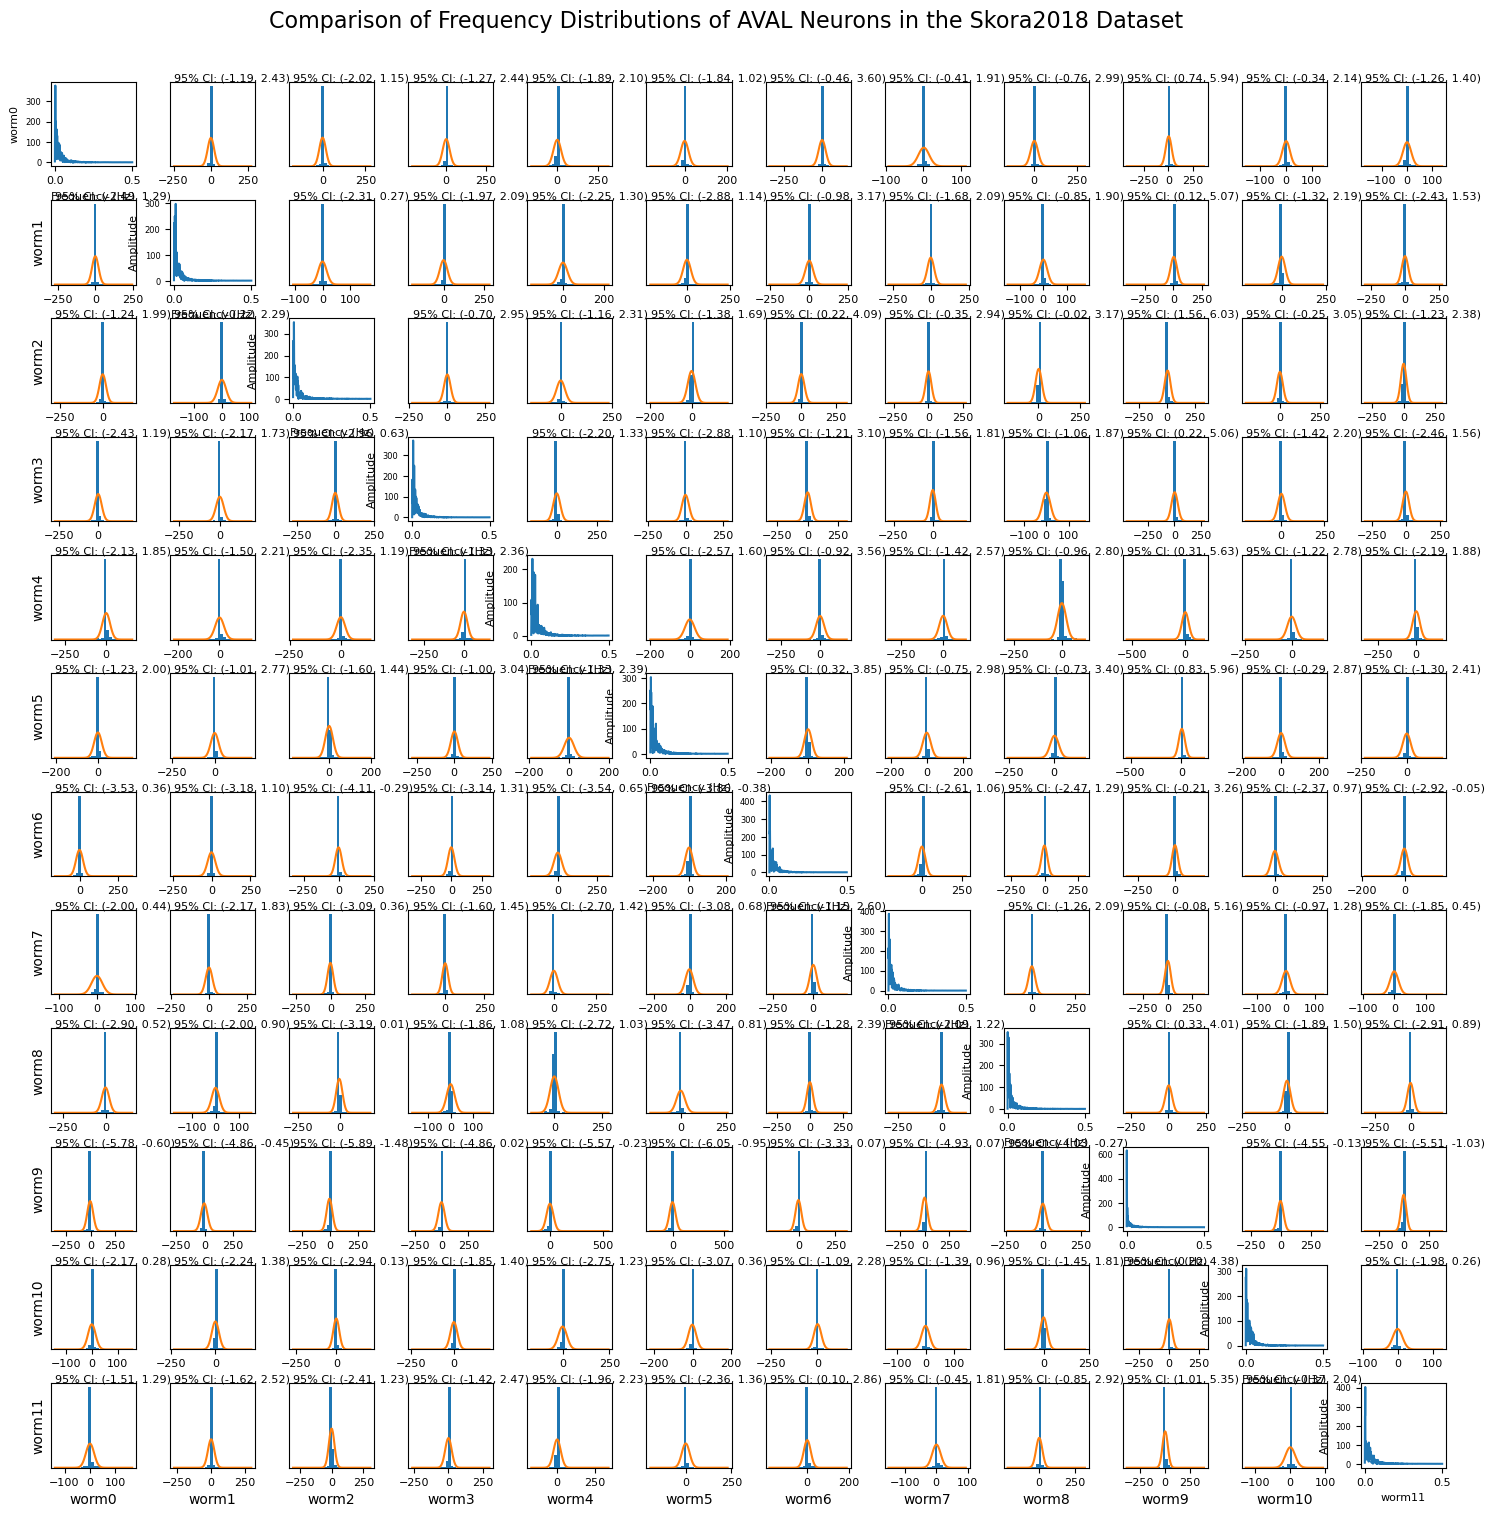

CPU times: user 19.3 s, sys: 53.7 ms, total: 19.3 s
Wall time: 20.5 s


In [ ]:
%%time

# Plot the frequency distributions for the AVAL neurons in the Skora2018 dataset
_ = compare_frequency_distributions(df_long, "Skora2018", "AVAL")

In [ ]:
def time_delay_embedding_3D(
    df_long,
    neuron_name,
    dataset_name,
    delay=1,
    num_instances=None,
    colormap="viridis",
    seed=None,
    show_legend=True,
    selected_legend=None,
):
    """
    Creates a 3D scatter plot of time-delayed embeddings for the calcium signals of a specified neuron across different worms from a specific dataset.

    This function first filters the input DataFrame for the specified neuron and dataset. It then filters out all data with calcium signals of 0. In case 'num_instances' is specified, the function randomly selects that number of unique worms from the filtered DataFrame.

    It generates a 3D scatter plot where each worm's data is represented by a separate line. The x, y, and z coordinates correspond to calcium data at different time steps. The color of each line is determined by a colormap.

    Parameters
    ----------
    df_long : pandas.DataFrame
        A DataFrame containing the dataset. It should have the columns 'neuron', 'worm', 'calcium_data', and 'dataset'.

    neuron_name : str
        The name of the neuron for which the embeddings will be generated and plotted.

    dataset_name : str
        The name of the dataset for which the embeddings will be generated and plotted.

    delay : int, optional
        The number of time steps to use for creating the delay embeddings. Default is 1.

    num_instances : int, optional
        The number of unique worms to include in the plot. If specified, random instances will be chosen from the available worms.
        Default is None, implying that data from all available worms will be used.

    colormap : str, optional
        The colormap to be used for the lines in the plot. Default is 'viridis'.

    seed : int, optional
        If specified, this will set the random seed before choosing the random instances. Default is None.

    show_legend : bool, optional
        If True, the legend is shown on the plot. Default is True.

    selected_legend : list of str, optional
        A list of worms that should be included in the legend. If None, all worms are included. Default is None.

    Returns
    -------
    None
        This function doesn't return anything; it generates a 3D scatter plot and displays it using plt.show().
    """
    if not isinstance(delay, int) or delay < 1:
        raise ValueError("delay must be a positive integer.")

    if num_instances is not None:
        if not isinstance(num_instances, int) or num_instances < 1:
            raise ValueError("num_instances must be either None or a positive integer.")

    # Filter the DataFrame for the neuron and dataset of interest
    df_neuron = df_long[
        (df_long["neuron"] == neuron_name) & (df_long["source_dataset"] == dataset_name)
    ]

    # Group by worm and filter out all 0.0s calcium data
    df_neuron = df_neuron.groupby("worm").filter(
        lambda x: not np.all(x["smooth_calcium_data"] == 0)
    )

    # Get unique worm identifiers
    unique_worms = df_neuron["worm"].unique()

    # If num_instances is specified, randomly select the instances
    if num_instances is not None:
        num_instances = min(num_instances, len(unique_worms))
        if seed is not None:
            np.random.seed(seed)
        unique_worms = np.random.choice(unique_worms, size=num_instances, replace=False)

    # Create a 3D line plot
    fig = plt.figure(figsize=(6, 6))  # Adjusted the figure size
    ax = fig.add_subplot(111, projection="3d")

    # Create a colormap for the worms
    colors = matplotlib.cm.get_cmap(colormap)(np.linspace(0, 1, len(unique_worms)))

    for worm, color in zip(unique_worms, colors):
        # Filter the DataFrame for the current worm
        df_worm = df_neuron[df_neuron["worm"] == worm]
        calcium_data = df_worm["smooth_calcium_data"].values

        # Create the time-delayed embeddings
        x = calcium_data[: -2 * delay]
        y = calcium_data[delay:-delay]
        z = calcium_data[2 * delay :]

        # Plot the embeddings for the current worm using a line
        ax.plot(x, y, z, color=color, alpha=0.7)

        if show_legend:
            if selected_legend is None or worm in selected_legend:
                ax.plot([], [], [], color=color, alpha=0.7, label=worm)

    # Customize the plot
    ax.set_title(
        f"3D Time Delay Embedding for {neuron_name} Neurons in {dataset_name} Dataset"
    )
    ax.set_xlabel(f"-{delay} $\\tau$")
    ax.set_ylabel(f"+{delay} $\\tau$")
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)
    ax.tick_params(axis="z", labelsize=8)

    # Invert the x-axis to move the z-axis to the left side
    ax.invert_xaxis()

    # Adjust the view angle
    ax.view_init(elev=20, azim=145)

    # Set the z-axis label position and rotation
    ax.zaxis.set_rotate_label(False)  # Disable auto rotation
    ax.zaxis.set_label_position("default")
    zlabel = ax.set_zlabel(f"$\\tau$", rotation=0, labelpad=0)

    if show_legend:
        ax.legend(title="Worm", loc="upper left")

    # Adjust subplot parameters
    plt.subplots_adjust(left=0.15, right=0.95, bottom=0.05, top=0.95)

    # Ensure everything fits well within the figure boundaries
    plt.tight_layout(rect=[0.15, 0, 1, 1])  # Adding more padding to the left
    plt.show()

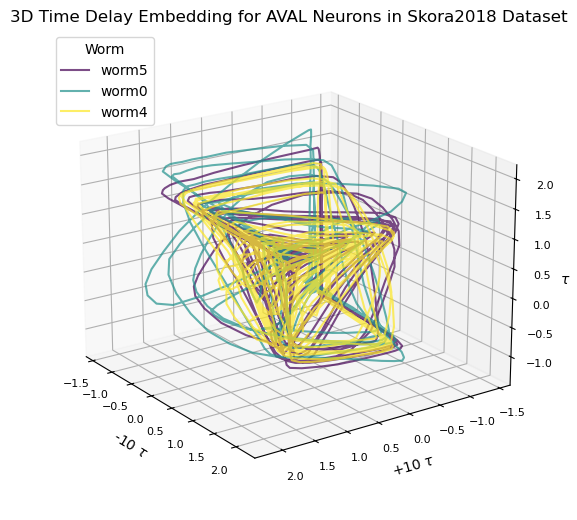

CPU times: user 4.42 s, sys: 29.7 ms, total: 4.45 s
Wall time: 4.51 s


In [ ]:
%%time

# Time-delayed embedding of some AVAL neurons in the Skora2018 dataset
time_delay_embedding_3D(df_long, "AVAL", "Skora2018", delay=10, num_instances=3)

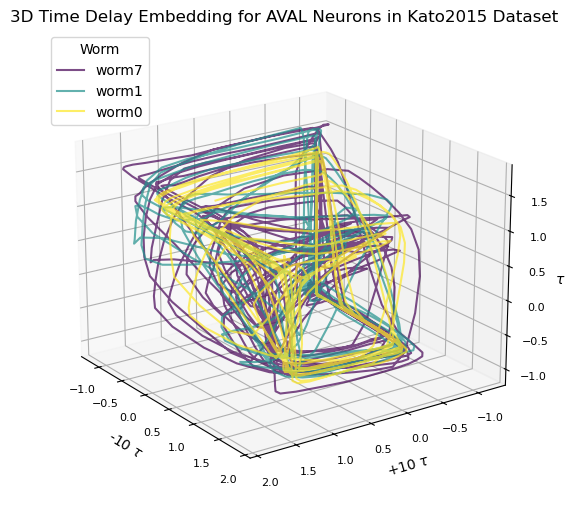

In [ ]:
time_delay_embedding_3D(df_long, "AVAL", "Kato2015", delay=10, num_instances=3)

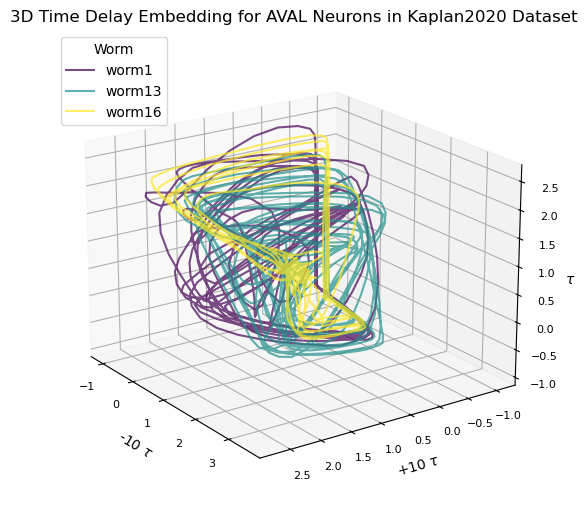

In [ ]:
time_delay_embedding_3D(df_long, "AVAL", "Kaplan2020", delay=10, num_instances=3)

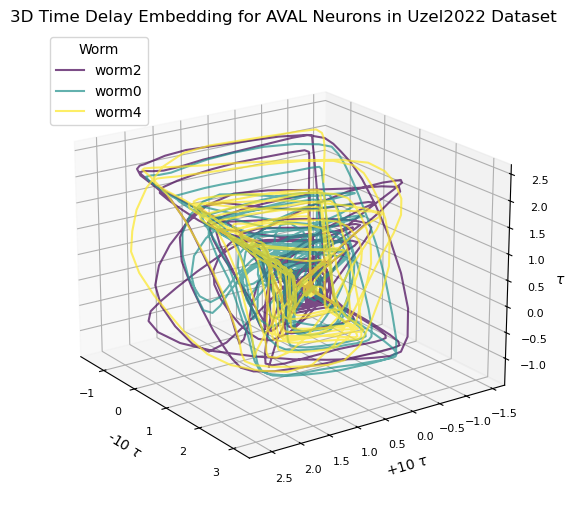

In [ ]:
time_delay_embedding_3D(df_long, "AVAL", "Uzel2022", delay=10, num_instances=3)

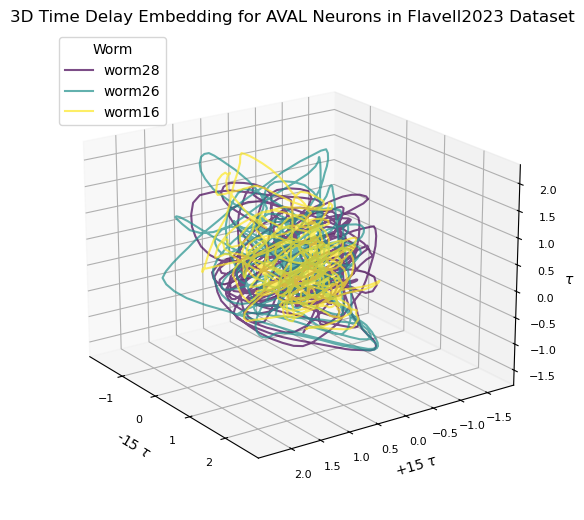

In [ ]:
time_delay_embedding_3D(df_long, "AVAL", "Flavell2023", delay=15, num_instances=3)

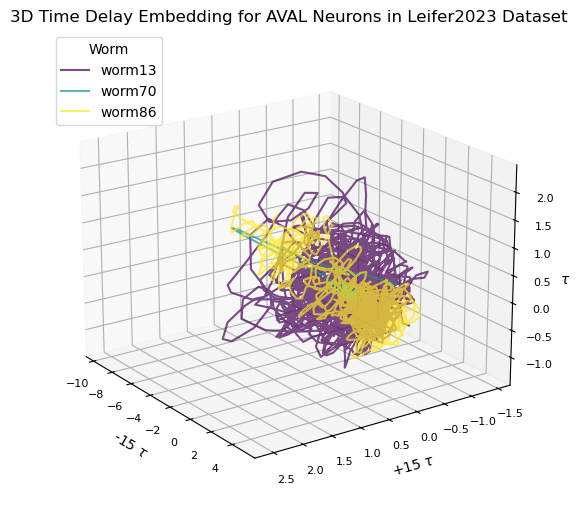

In [ ]:
time_delay_embedding_3D(df_long, "AVAL", "Leifer2023", delay=15, num_instances=3)